<div style="text-align: right">Author: Yuktha Bhadane (yb294@cornell.edu)</div>

### Phase Out Order: Bar Chart
This notebook visualizes power plant phaseout scenarios for the set of eight developing countries
(India, Indonesia, South Africa, Mexico, Viet Nam, Iran, Thailand, and Egypt), comparing different phaseout criteria as a bar chart.

0. Set up

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def load_scenario_data(path):
    """
    Load scenario data from CSV and organize by country and year.
    
    Parameters:
    path (str): Path to scenario CSV file
    
    Returns:
    dict: Nested dictionary with countries and their yearly emission totals
    """
    df = pd.read_csv(path)
    year_cols = [str(year) for year in range(2024, 2051)]
    
    scenario_data = {}
    for country in df['Region'].unique():
        country_data = df[df['Region'] == country]
        yearly_totals = {}
        
        for year in year_cols:
            year_total = country_data[year].sum()
            yearly_totals[int(year)] = year_total
                
        scenario_data[country] = yearly_totals
    
    return scenario_data

def load_and_process_data(base_path, country_code):
    """
    Load and process power plant data for a specific country.
    
    Parameters:
    base_path (str): Base directory containing CSV files
    country_code (str): Two-letter country code
    
    Returns:
    dict: Dictionary of DataFrames with processed data for each phaseout scenario
    """
    files = {
        'maturity': f'v2_power_plant_phaseout_order_by_maturity_{country_code}_2050.csv',
        'emission_factor': f'v2_power_plant_phaseout_order_by_emission_factor_{country_code}_2050.csv',
        'benefits_cost_maturity': f'v2_power_plant_phaseout_order_by_emissions_per_OC_maturity_{country_code}_2050.csv'
    }
    
    dfs = {}
    for key, filename in files.items():
        file_path = Path(base_path) / filename
        df = pd.read_csv(file_path)
        
        annual_data = []
        current_rank = 1
        cumulative_emissions = 0
        
        available_years = sorted(df['year'].unique())
        all_years = list(range(2024, 2051))
        
        for year in all_years:
            if year in available_years:
                year_plants = df[df['year'] == year]
                
                # Consider the fraction column for calculating effective number of plants
                if 'fraction' in year_plants.columns:
                    # Sum of fractions gives effective number of plants
                    effective_n_plants = year_plants['fraction'].sum()
                    # Calculate weighted rank increment based on fraction
                    rank_increment = effective_n_plants
                else:
                    # If fraction column doesn't exist, use traditional count
                    effective_n_plants = len(year_plants)
                    rank_increment = effective_n_plants
                
                year_emissions = year_plants['amount_mtco2'].sum()
                cumulative_emissions += year_emissions
                
                # Create default dictionary for subsectors
                subsector_dict = {'Coal': 0, 'Gas': 0, 'Oil': 0}
                # Update with actual values
                for subsector, amount in year_plants.groupby('subsector')['amount_mtco2'].sum().to_dict().items():
                    subsector_dict[subsector] = amount
                
                annual_data.append({
                    'year': year,
                    'amount_mtco2': year_emissions,
                    'cumulative_mtco2': cumulative_emissions,
                    'start_rank': current_rank,
                    'end_rank': current_rank + rank_increment,
                    'n_plants': effective_n_plants,
                    'plants_by_subsector': subsector_dict
                })
                current_rank += rank_increment
            else:
                annual_data.append({
                    'year': year,
                    'amount_mtco2': 0,
                    'cumulative_mtco2': cumulative_emissions,
                    'start_rank': current_rank,
                    'end_rank': current_rank,
                    'n_plants': 0,
                    'plants_by_subsector': {'Coal': 0, 'Gas': 0, 'Oil': 0}
                })
        
        dfs[key] = pd.DataFrame(annual_data)
    
    return dfs

1. Visualisation

In [12]:
def create_visualization(country_code, country_name, base_path, bau_data, scenario_data):
    """
    Create visualization of power plant phaseout scenarios.
    
    Parameters:
    country_code (str): Two-letter country code
    country_name (str): Full country name
    base_path (str): Base directory containing CSV files
    bau_data (dict): Business-as-usual data for the country
    scenario_data (dict): Scenario data for the country
    
    Returns:
    matplotlib.figure.Figure: Figure containing the visualization
    """
    dfs = load_and_process_data(base_path, country_code)
    
    fig, axes = plt.subplots(3, 1, figsize=(20, 20))
    
    titles = {
        'maturity': 'By Power Plant Maturity',
        'emission_factor': 'By Power Plant Emission Intensity',
        'benefits_cost_maturity': 'By Power Plant Benefits/Costs (Including Plant Maturity)'
    }
    
    colors = {'Coal': '#8B4513', 'Gas': '#DAA520', 'Oil': '#2F4F4F'}
    
    fuel_patches = [plt.Rectangle((0,0), 1, 1, facecolor=colors[fuel], alpha=0.7) 
                   for fuel in ['Coal', 'Gas', 'Oil']]
    
    line_patches = [
        plt.Line2D([0], [0], color='black', linestyle='--'),
        plt.Line2D([0], [0], color='grey', linestyle='--'),
        plt.Line2D([0], [0], color='grey', linestyle=':')
    ]
    
    # Moved legends to the bottom
    fig.text(0.5, 0.06, '(N) = Number of plants shut down in that year\nStart Rank → End Rank of plants in phase-out sequence',
             fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    for idx, (key, df) in enumerate(dfs.items()):
        ax = axes[idx]
        ax2 = ax.twinx()
        
        years = list(range(2024, 2051))
        max_emissions = df['amount_mtco2'].max()
        min_val = -max_emissions*0.1
        
        annual_totals = df['amount_mtco2'].values
        ax.plot(years, annual_totals, 'k--', linewidth=2)
        
        for i, row in df.iterrows():
            bottom = 0
            for subsector, amount in row['plants_by_subsector'].items():
                ax.bar(row['year'], amount, bottom=bottom, 
                      color=colors[subsector], alpha=0.7,
                      width=0.9) 
                bottom += amount
            
            total_height = sum(row['plants_by_subsector'].values())
            
            if total_height > 0:
                # Black text (ranks) rounded to integers
                ax.text(row['year'], min_val*0.5,
                       f'{int(round(row["start_rank"]))}', 
                       ha='center', va='top',
                       fontsize=10)
                ax.text(row['year'], total_height + max_emissions*0.08, 
                       f'{int(round(row["end_rank"]))}', 
                       ha='center', va='bottom',
                       fontsize=10)
                # White text (plant counts) kept with one decimal place
                ax.text(row['year'], total_height/2, 
                       f'({row["n_plants"]:.1f})',
                       ha='center', va='center', 
                       color='white', 
                       fontweight='bold', fontsize=11)
        
        # Calculate cumulative difference from 2024 levels for scenario pathway
        cumulative_from_2024 = []
        for year in years:
            if year == 2024:
                cumulative_from_2024.append(0)
            else:
                total_diff = sum(scenario_data[2024] - scenario_data[y] for y in range(2024, year + 1))
                cumulative_from_2024.append(total_diff)
        
        # Calculate cumulative BAU vs scenario difference
        cumulative_bau_scenario = []
        for year in years:
            if year == 2024:
                cumulative_bau_scenario.append(0)
            else:
                bau_sum = sum(bau_data[y] for y in range(2024, year + 1))
                scenario_sum = sum(scenario_data[y] for y in range(2024, year + 1))
                year_difference = (bau_sum - scenario_sum)
                cumulative_bau_scenario.append(year_difference)
        
        ax2.plot(years, cumulative_from_2024, color='grey', linestyle='--', linewidth=1)
        ax2.plot(years, cumulative_bau_scenario, color='grey', linestyle=':', linewidth=1)
        
        ax.set_title(titles[key], pad=20, fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Annual Emission Reduction (MtCO2)', fontsize=12, labelpad=10)
        ax2.set_ylabel('Cumulative avoided emissions (GtCO2)', fontsize=12, labelpad=10)
        
        y2_ticks = ax2.get_yticks()
        ax2.set_yticklabels(['{:.1f}'.format(y/1000) for y in y2_ticks])
        
        max_cumulative = max(max(cumulative_from_2024), max(cumulative_bau_scenario))
        
        ax.set_ylim(min_val, max_emissions*1.2)
        ax2.set_ylim(min_val, max_cumulative*1.2)
        
        ax.tick_params(axis='both', labelsize=12)
        ax2.tick_params(axis='both', labelsize=12)
        
        ax.set_xticks(np.arange(2025, 2055, 5))
        ax.set_xticklabels([str(year) for year in range(2025, 2055, 5)])
        
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        
        ax.grid(True, alpha=0.3, linestyle='--')
    
    # Moved legends to bottom
    fig.legend(fuel_patches, ['Coal', 'Gas', 'Oil'],
              loc='lower center', bbox_to_anchor=(0.5, 0.09), ncol=3, fontsize=14)
    
    fig.legend(line_patches, 
              ['Annual emissions reduction',
               'Cumulative avoided emissions\nrelative to current emission levels',
               'Cumulative avoided emissions\nrelative to BAU'],
              loc='lower center', bbox_to_anchor=(0.5, 0.06), ncol=3, fontsize=14)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15) # Adjusted to make room for legends at bottom
    return fig

2. Execution

In [13]:
# Note: Update these paths to local or relative paths for GitHub
# Using absolute paths 
base_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Phase out data" 
bau_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Scenarios Files/annual BAU .csv" 
scenario_path = "/Users/yukthabhadane/Documents/Climate Finance Thesis/Paper Alissa Jan 2025/Scenarios Files/Annual 1.5 50.csv"
    
# ISO code mapping
iso_mapping = {
    'IN': 'IND', 'ID': 'IDN', 'ZA': 'ZAF', 'MX': 'MEX', 
    'VN': 'VNM', 'IR': 'IRN', 'TH': 'THA', 'EG': 'EGY'
}

# Country information
countries = ['IN', 'ID', 'ZA', 'MX', 'VN', 'IR', 'TH', 'EG']
country_names = {
    'IN': 'India', 'ID': 'Indonesia', 'ZA': 'South Africa',
    'MX': 'Mexico', 'VN': 'Vietnam', 'IR': 'Iran', 
    'TH': 'Thailand', 'EG': 'Egypt'
}

3. Example: Running for India

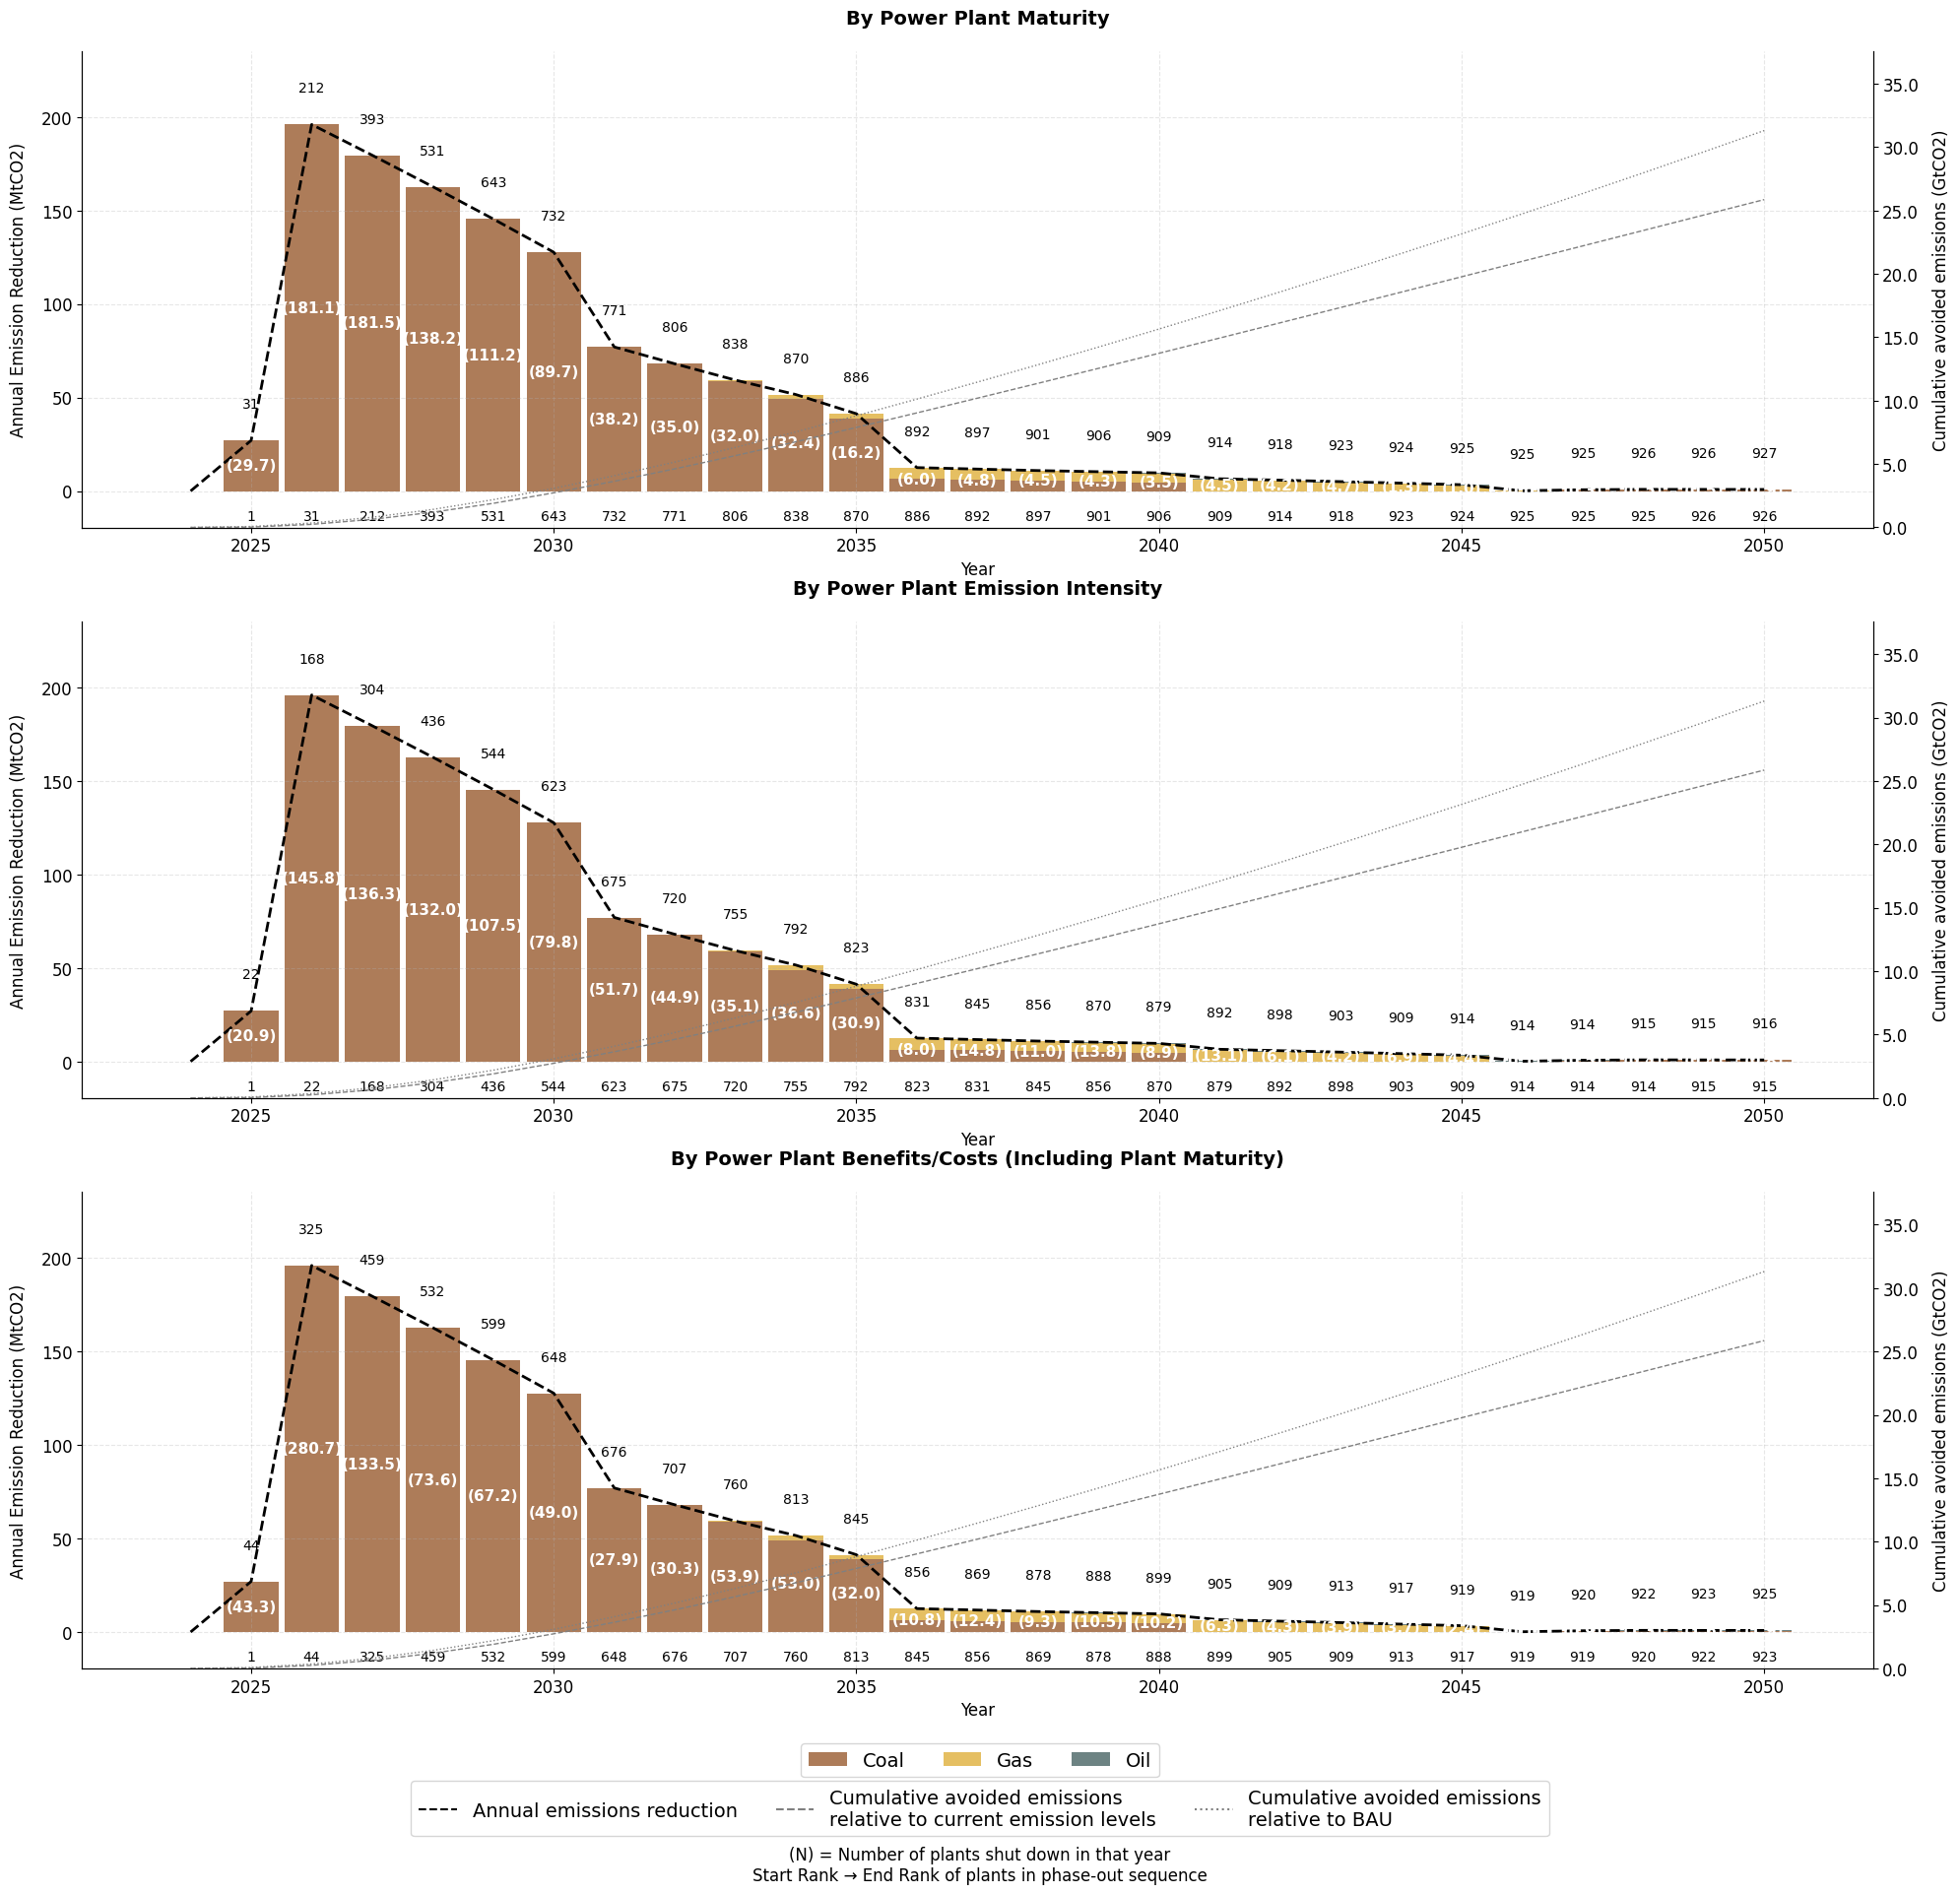

In [14]:
country = 'IN'
# Load scenario data 
bau_processed = load_scenario_data(bau_path)
scenario_processed = load_scenario_data(scenario_path)

# Create and display visualization
fig = create_visualization(
    country, 
    country_names[country], 
    base_path, 
    bau_processed[iso_mapping[country]],
    scenario_processed[iso_mapping[country]]
)
plt.show()

4. Generate Visualizations for all 8 Countries

In [15]:
# Load scenario data
bau_processed = load_scenario_data(bau_path)
scenario_processed = load_scenario_data(scenario_path)

# Create output directory in the same location as this notebook
output_dir = Path("phase_out_order_bar_charts")
output_dir.mkdir(exist_ok=True, parents=True)

# Create and save visualizations for all countries
for country in countries:
    print(f"\nProcessing {country_names[country]}...")
    fig = create_visualization(
        country, 
        country_names[country], 
        base_path, 
        bau_processed[iso_mapping[country]],
        scenario_processed[iso_mapping[country]]
    )
    
    # Save the figure to the output directory
    output_file = output_dir / f"phaseout_order_{country}.png"
    fig.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close(fig)  # Close the figure to free memory
    
    print(f"Saved plot for {country_names[country]} to {output_file}")


Processing India...
Saved plot for India to phase_out_order_bar_charts/phaseout_order_IN.png

Processing Indonesia...
Saved plot for Indonesia to phase_out_order_bar_charts/phaseout_order_ID.png

Processing South Africa...
Saved plot for South Africa to phase_out_order_bar_charts/phaseout_order_ZA.png

Processing Mexico...
Saved plot for Mexico to phase_out_order_bar_charts/phaseout_order_MX.png

Processing Vietnam...
Saved plot for Vietnam to phase_out_order_bar_charts/phaseout_order_VN.png

Processing Iran...
Saved plot for Iran to phase_out_order_bar_charts/phaseout_order_IR.png

Processing Thailand...
Saved plot for Thailand to phase_out_order_bar_charts/phaseout_order_TH.png

Processing Egypt...
Saved plot for Egypt to phase_out_order_bar_charts/phaseout_order_EG.png
